# Setting up environment

In [1]:
import pickle
import numpy as np
import scipy
import scipy.io as sio
import sys
from scipy.spatial import distance
sys.path.append('..')
import random

In [2]:
data_prefix = ''

# Getting the Data from a Predefined Matrix [Scraped a while ago by Svebor]

Labels is a list showing which person corresponds to which image [Note: there are some people that show up multiple times]

In [3]:
# how to load ground truth labels
gt_name = 'LFW_all_subjects_id.mat'
gt_file_full = data_prefix + gt_name
gt_mat = sio.loadmat(gt_file_full)
labels = np.squeeze(gt_mat['all_subjects_ids'])
print labels

[   0    1    2 ..., 5746 5747 5748]


There are 5748 People in this LFW dataset

# Loading 512 bit long hashcodes that were generated from the hash layer of the neural network

In [4]:
# how to load hashcodes
hashcodes_name = 'LFW_hash512_randomcrop_prelu_newproto_rgb_notV7.3.mat'
hashcodes_file_full = data_prefix + hashcodes_name
hashcodes_mat = sio.loadmat(hashcodes_file_full)
#print hashcodes_mat['templates']
all_templates = hashcodes_mat['templates']
# all templates contains: subject_name, subject_id, file, features (actually hashcodes in this case)
nb_samples = hashcodes_mat['templates'].shape[1]
all_samples_tmp = []
all_samples_files = []
for i in range(nb_samples):
    all_samples_tmp.append(np.squeeze(all_templates[0,i][3]))
    all_samples_files.append(str(np.squeeze(all_templates[0,i][2])))
all_samples = np.asarray(all_samples_tmp)

In [5]:
print all_samples_files[:10]

['AJ_Cook_0001.jpg', 'AJ_Lamas_0001.jpg', 'Aaron_Eckhart_0001.jpg', 'Aaron_Guiel_0001.jpg', 'Aaron_Patterson_0001.jpg', 'Aaron_Peirsol_0001.jpg', 'Aaron_Peirsol_0002.jpg', 'Aaron_Peirsol_0003.jpg', 'Aaron_Peirsol_0004.jpg', 'Aaron_Pena_0001.jpg']


In [6]:
print all_samples[:2,:]
# hash codes should actually be binarized.
# Check what is the best way to represent binary codes in python
print (all_samples>0.5)[:2,:]
print all_samples.shape

[[  9.99719501e-01   9.99999583e-01   9.92673457e-01 ...,   1.00000000e+00
    1.00000000e+00   1.06802311e-07]
 [  6.81201158e-08   3.98614723e-03   1.00000000e+00 ...,   9.99999821e-01
    2.63930566e-12   7.86280156e-12]]
[[ True  True  True ...,  True  True False]
 [False False  True ...,  True False False]]
(13233, 512)


# Getting distances between each hashcode

In [7]:
# how to load precomputed distance matrix
fulldist_name = 'LFW_full_hamming_dist.mat'
fulldist_file = data_prefix + fulldist_name
fulldist = sio.loadmat(fulldist_file)

In [8]:
fulldist_np = fulldist['full_hamming_dist']

In [9]:
fulldist_np.shape

(13233, 13233)

In [10]:
print fulldist_np[100][10001]

253


# Scraping LFW dataset from CAVE

In [11]:

f = open('lfw_attributes.txt', 'r')

f.readline() # Header
f.readline() # Attributes List

counter = 0
prev = ''
same = []
same_arr = []

for line in f:


    line1 = line.split("\n")[0]
    arr = line1.split()

    name = arr[0]
    count = 1
    while count < len(arr) - 73 - 1:
        name = name + '_' + arr[count]
        count += 1

    if name == prev:
        same_arr.append(counter)
    else:
        if len(same_arr) > 1:
            same.append(same_arr)
        prev = name
        same_arr = [counter]
    counter += 1
if len(same_arr) > 1:
    same.append(same_arr)

print len(same)

tuples = []
for person in same:
    i = 0
    while i < len(person):
        j = i + 1
        while j < len(person):
            tuples.append((person[i], person[j]))
            j += 1
        i += 1
print len(tuples)

1670
237856


In [12]:
# Threshold for determining whether the attribute value is 0 or 1
threshold = 0.0

In [13]:
names = []

def calculate_data(attr_set):
    attribute_number = len(attr_set)

    f = open('lfw_attributes.txt', 'r')

    f.readline() # Header
    f.readline() # Attributes List

    labels = []
    data = []
    counter = 0

    for line in f:

        line1 = line.split("\n")[0]
        arr = line1.split()

        name = arr[0]
        count = 1
        while count < len(arr) - 73 - 1:
            name = name + '_' + arr[count]
            count += 1
        names.append(name)
        labels.append(name+'_'+arr[count].zfill(4) + '.jpg')
        f_arr = arr[count + 1: len(arr)]

        features = []
        attribute_number = 0
        for elem in f_arr:
            if attribute_number in attr_set:
                if float(elem) < 0:
                    features.append(0)
                else:
                    features.append(1)
            attribute_number+=1
        data.append(features)

            
    return np.array(data), labels



sex = [0]
ethnicity = [1,2,3,57]
age = [4,5,6,7,8]
hair_color = [9,10,11,12,58]
glasses = [13,14]
facial_hair = [16,45,46]
hair_style = [25,26,27,28,29,30]
eyebrows = [34,35]
eye = [36,69]
facial_structure = [19,38,39,40,47,48,50,51,52,68]

identity = set(sex+ethnicity+age+hair_color+glasses+facial_hair+hair_style+eyebrows+eye+facial_structure)

picture_quality = [20,21,22,23,53,54]
click_specifics = [31,32,33,37,41,42,43,44]
makeup = [59,60,61,62,63,64,65,66,67]
attractiveness = [55,56]
emotions = [17,18]
accessories = [15,24,49,70,71,72]

irrelevant = set(picture_quality+click_specifics+makeup+attractiveness+emotions+accessories)

everything = irrelevant.union(identity)


data, labels = calculate_data(everything)

In [14]:
len(data)

13143

In [15]:
hi = set(names)
print len(hi)

5721


In [16]:
labels[3400]

'Eminem_0001.jpg'

# Figuring out which images are not present in both datasets

In [17]:
dictionary = {}
for elem in labels:
    dictionary[elem] = True
count = 0
colDel = []
for elem in all_samples_files:
    if elem not in dictionary:
        colDel.append(count)
    count += 1

print len(colDel)

90


## Deleting the respective columns and rows

In [18]:
count = len(colDel) - 1
hash_np_revised = fulldist_np
while count >= 0:
    temp = np.delete(hash_np_revised, colDel[count], 0)
    hash_np_revised = np.delete(temp, colDel[count], 1)
    count = count - 1
    

In [19]:
print hash_np_revised.shape
print fulldist_np.shape

(13143, 13143)
(13233, 13233)


## Normalizing Data

In [20]:
normalized_hash_dist= hash_np_revised/512.0

In [21]:
print data.shape
print data[0]

(13143, 73)
[1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1
 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0]


In [22]:
data_dist = distance.cdist(data, data, 'hamming')

In [23]:
def get_average(data):
    data_dist = distance.cdist(data, data, 'hamming')
    return find_0_1(normalized_hash_dist, data_dist)[0]


In [24]:
total = np.sum(np.absolute(np.subtract(normalized_hash_dist, data_dist)))

from scipy.spatial import distance
hash_dist = distance.cdist(all_samples, all_samples, 'euclidean')

In [25]:
average = total / (13143*13143 - 13143)

In [26]:
average

0.14867188197040984

In [27]:
def find_0_1(arr1, arr2):
    arr1_0_1 = arr1 / (np.max(arr1))
    arr2_0_1 = arr2 / (np.max(arr2))
    total = np.sum(np.absolute(np.subtract(arr1_0_1, arr2_0_1)))
    return (total / (13143*13143 - 13143)), arr1_0_1, arr2_0_1


In [28]:
print find_0_1(normalized_hash_dist, data_dist)

(0.18880147187839005, array([[ 0.        ,  0.55813953,  0.66408269, ...,  0.63565891,
         0.71059432,  0.67700258],
       [ 0.55813953,  0.        ,  0.70542636, ...,  0.63049096,
         0.74160207,  0.64599483],
       [ 0.66408269,  0.70542636,  0.        , ...,  0.74160207,
         0.67183463,  0.55555556],
       ..., 
       [ 0.63565891,  0.63049096,  0.74160207, ...,  0.        ,
         0.62273902,  0.63049096],
       [ 0.71059432,  0.74160207,  0.67183463, ...,  0.62273902,
         0.        ,  0.61757106],
       [ 0.67700258,  0.64599483,  0.55555556, ...,  0.63049096,
         0.61757106,  0.        ]]), array([[ 0.        ,  0.33333333,  0.38888889, ...,  0.68518519,
         0.44444444,  0.18518519],
       [ 0.33333333,  0.        ,  0.53703704, ...,  0.5       ,
         0.33333333,  0.37037037],
       [ 0.38888889,  0.53703704,  0.        , ...,  0.62962963,
         0.53703704,  0.35185185],
       ..., 
       [ 0.68518519,  0.5       ,  0.62962963, ...

# Attributes

In [29]:
sex = [0]
ethnicity = [1,2,3,57]
age = [4,5,6,7,8]
hair_color = [9,10,11,12,58]
glasses = [13,14]
facial_hair = [16,45,46]
hair_style = [25,26,27,28,29,30]
eyebrows = [34,35]
eye = [36,69]
facial_structure = [19,38,39,40,47,48,50,51,52,68]

identity = set(sex+ethnicity+age+hair_color+glasses+facial_hair+hair_style+eyebrows+eye+facial_structure)

picture_quality = [20,21,22,23,53,54]
click_specifics = [31,32,33,37,41,42,43,44]
makeup = [59,60,61,62,63,64,65,66,67]
attractiveness = [55,56]
emotions = [17,18]
accessories = [15,24,49,70,71,72]

irrelevant = set(picture_quality+click_specifics+makeup+attractiveness+emotions+accessories)

everything = irrelevant.union(identity)


In [30]:
print get_average(calculate_data(identity)[0])
    

0.21976666158


In [31]:
print get_average(calculate_data(irrelevant)[0])
print get_average(calculate_data(everything)[0])

0.24420051787
0.188801471878


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:

tuples_random = []
i = 0
while i < 100:
    x = random.randrange(0,len(tuples) - 1)
    tuples_random.append(tuples[i])
    i+= 1


In [69]:
def plot_b(data1):
    count = 0
    inputs = []

    data_dist1 = distance.cdist(data1, data1, 'hamming')
    
    x = []
    y = []
    num,x_a, y_a = find_0_1(normalized_hash_dist, data_dist1)
    
    for elem in tuples_random:
        x.append(x_a[elem[0]][elem[1]])
        y.append(y_a[elem[0]][elem[1]])
    plt.scatter(x,y, color = 'blue')
    plt.show()


In [66]:
print str(tuples[0])

(3, 4)


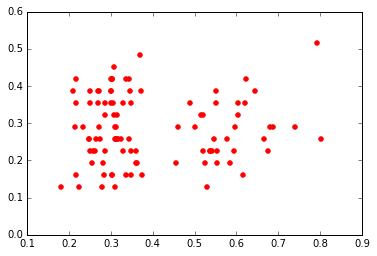

In [67]:
plot_b(calculate_data(identity)[0])

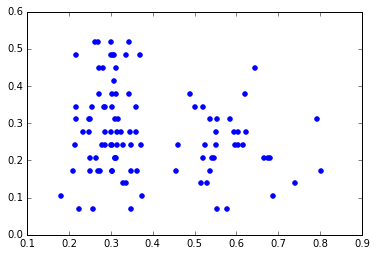

In [70]:
plot_b(calculate_data(irrelevant)[0])

In [47]:
def hist_ready(arr1):
    arr1_0_1 = arr1 / (np.max(arr1) - 0)
    
    
    return arr1_0_1

submit = []
hist_arr = hist_ready(normalized_hash_dist)

In [48]:
submit = []
for elem in tuples:
    submit.append(hist_arr[elem[0], elem[1]])

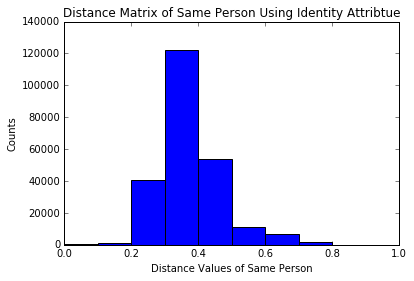

In [49]:
import matplotlib.pyplot as plt
from numpy.random import normal
plt.hist(submit, bins = 10, range = [0,1])
plt.title("Distance Matrix of Same Person Using Identity Attribtue")
plt.xlabel("Distance Values of Same Person")
plt.ylabel("Counts")
plt.show()

In [50]:
data_identity = calculate_data(identity)[0]
data_irrelevant = calculate_data(irrelevant)[0]


In [51]:
data_identity1 = distance.cdist(data_identity, data_identity, 'hamming')
data_irrelevant1 = distance.cdist(data_irrelevant, data_irrelevant, 'hamming')

In [52]:
data_identity1 = data_identity1 / np.max(data_identity1)
data_irrelevant1 = data_irrelevant1 / np.max(data_irrelevant1)

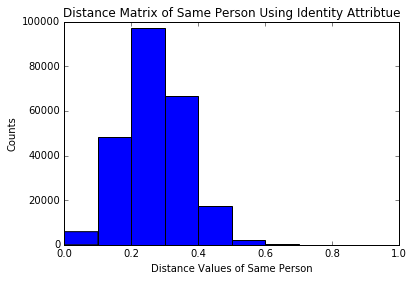

In [73]:
submit = []
for elem in tuples:
    submit.append(data_identity1[elem[0], elem[1]])
plt.hist(submit, bins = 10, range = [0,1])
plt.title("Distance Matrix of Same Person Using Identity Attribtue")
plt.xlabel("Distance Values of Same Person")
plt.ylabel("Counts")
plt.show()

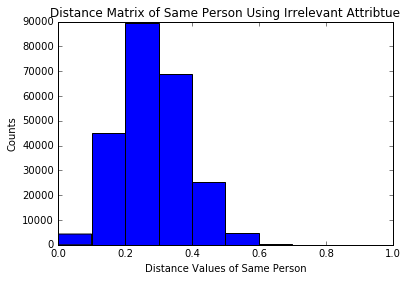

In [74]:
submit = []
for elem in tuples:
    submit.append(data_irrelevant1[elem[0], elem[1]])
plt.hist(submit, bins = 10, range = [0,1])
plt.title("Distance Matrix of Same Person Using Irrelevant Attribtue")
plt.xlabel("Distance Values of Same Person")
plt.ylabel("Counts")
plt.show()